# 1. Importing libraries

In [2]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Custom functions and classes
# -----------------------------------------------------------------------
from src.support_preprocess import preprocess
from src.support_eda import plot_relation_tv
from src.support_clustering import *

# 2. Data loading

In [3]:
df = pd.read_csv('../data/processed/products.csv', index_col=0)

df.head()

,Category,Sub-Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
ProductID,,,,,,,
FUR-ADV-10000002,Furniture,Furnishings,2,159.120,3,60.390,10.14
FUR-ADV-10000108,Furniture,Furnishings,3,350.070,7,3.360,22.90
FUR-ADV-10000183,Furniture,Furnishings,8,974.832,31,-651.738,100.02
FUR-ADV-10000188,Furniture,Furnishings,5,124.950,7,4.200,16.53
FUR-ADV-10000190,Furniture,Furnishings,1,222.360,2,104.460,32.71


# 3. Preprocessing  

In this version b, we will try a different preprocessing approach:  

- Remove the columns we do not want to consider:* 
  - In this case, we will remove `Sub-Category`, as it is a subset of `Category`.  

- Select the encoding methods for categorical variables:
  - We only have the categorical variable `Category`. We will perform Frequency Encoding.  

- Select the scaling method:
  - This time, we will use a MinMaxScaler to perform standardization.  

In [4]:
cols = ['Sub-Category']

encoding_methods = {"frequency": ['Category']}

scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling, columns_drop=cols)

In [5]:
df_encoded.head()

,Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
ProductID,,,,,,
FUR-ADV-10000002,0.216479,2,159.120,3,60.390,10.14
FUR-ADV-10000108,0.216479,3,350.070,7,3.360,22.90
FUR-ADV-10000183,0.216479,8,974.832,31,-651.738,100.02
FUR-ADV-10000188,0.216479,5,124.950,7,4.200,16.53
FUR-ADV-10000190,0.216479,1,222.360,2,104.460,32.71


In [6]:
df_scaled.head()

,Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
ProductID,,,,,,
FUR-ADV-10000002,0.0,0.030303,0.002557,0.012346,0.262335,0.002580
FUR-ADV-10000108,0.0,0.060606,0.005657,0.037037,0.260662,0.005833
FUR-ADV-10000183,0.0,0.212121,0.015799,0.185185,0.241439,0.025492
FUR-ADV-10000188,0.0,0.121212,0.002002,0.037037,0.260687,0.004209
FUR-ADV-10000190,0.0,0.000000,0.003583,0.006173,0.263628,0.008333


# 4. Clustering

We are going to implement different clustering algorithms to see how the products are segmented.

## 4.1 K-means

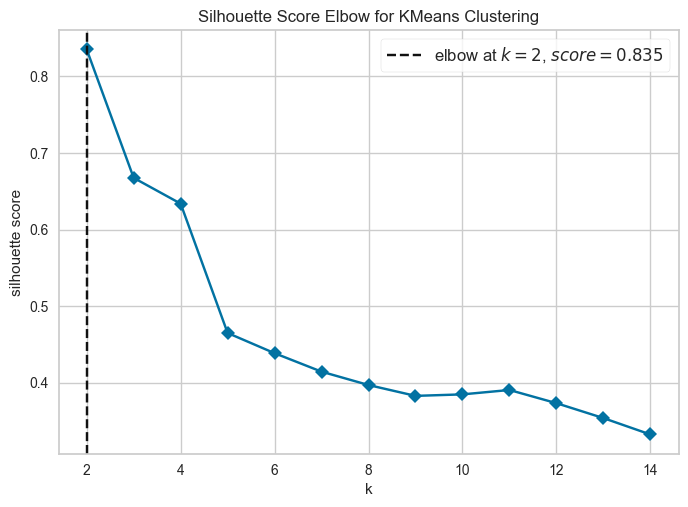

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [7]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=False)
visualizer.fit(df_scaled)
visualizer.show()

Using the elbow technique and the selected preprocessing, we obtain two clusters, $k = 2$, with a silhouette score of 0.835 (close to 1).  

This indicates that the data are well-grouped into two clusters, with no significant overlap between them.

In [8]:
model_kmeans = KMeans(n_clusters=2)

km_fit = model_kmeans.fit(df_scaled)
labels = km_fit.labels_

### 4.1.1 Metrics

In [9]:
clustering_metrics(df_scaled, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.83521,0.240917,4603
1,0.83521,0.240917,5689


We observe a Davies-Bouldin index of 0.24, where the value being close to 0 indicates good compactness and adequate separation between the clusters.  

Additionally, looking at the cardinality of the clusters, we can confirm that both have a good size, with no significant imbalances.

### 4.1.2 Cluster exploration

In this section, we will compare the obtained clusters to identify their properties.

In [10]:
df_kmeans = df_scaled.copy()

df_kmeans['cluster'] = km_fit.labels_

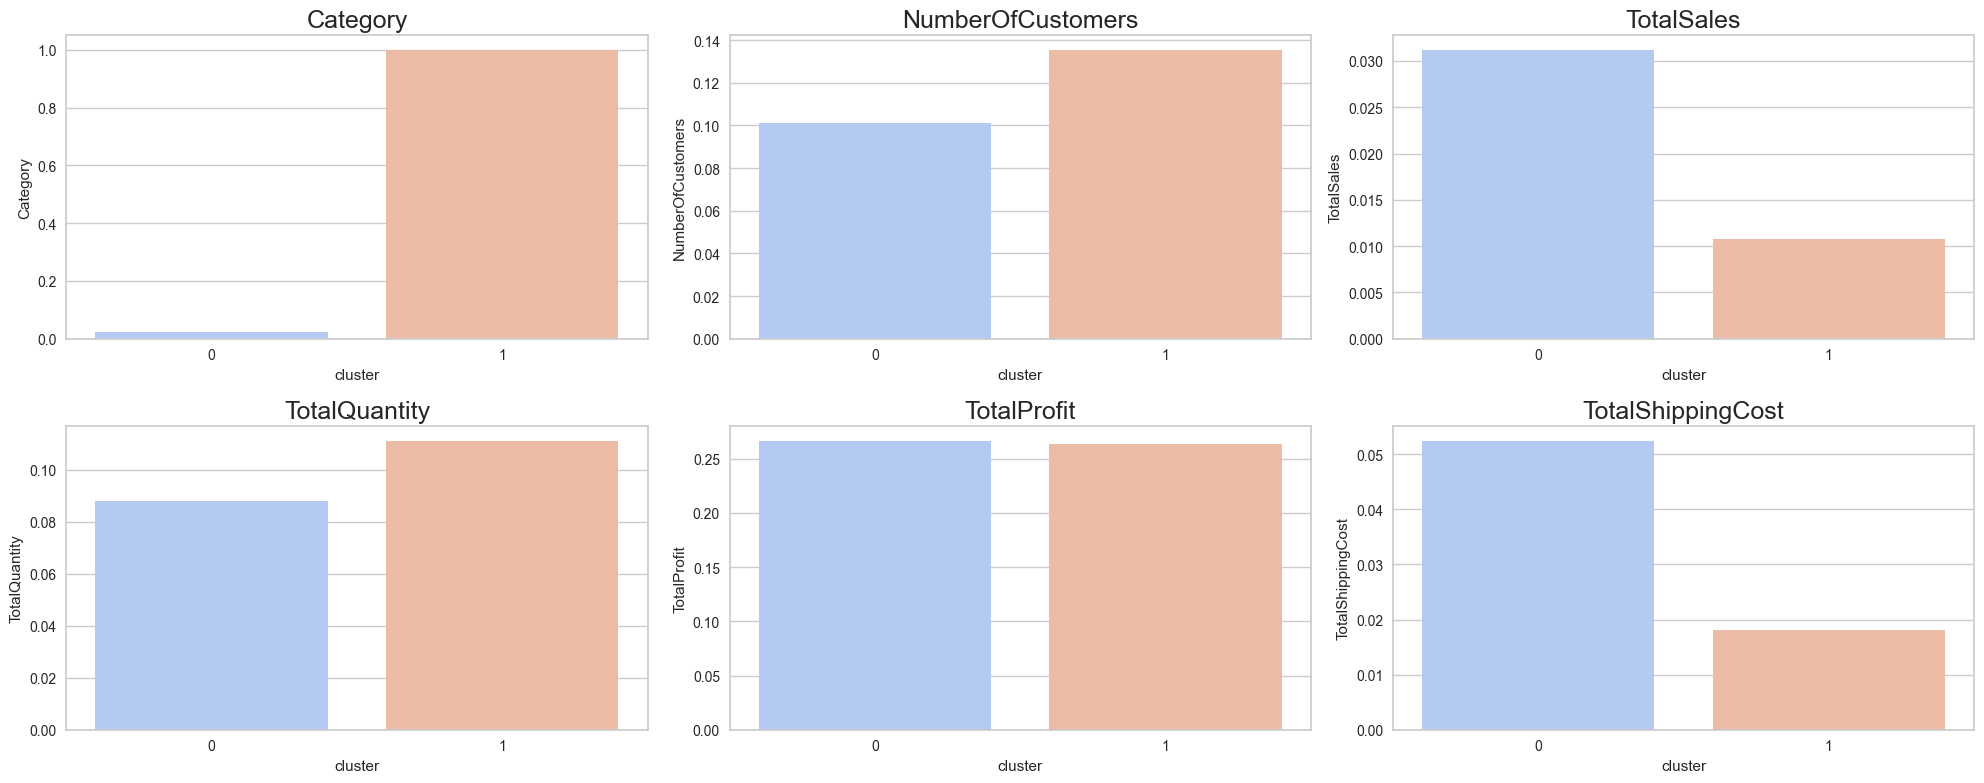

In [11]:
plot_clusters(df_kmeans)

It seems that what characterizes these clusters are the product categories and, consequently, the other variables.

### Radar plot

By creating a radar chart, we can also observe the differences between clusters. Let’s represent the numerical variables.

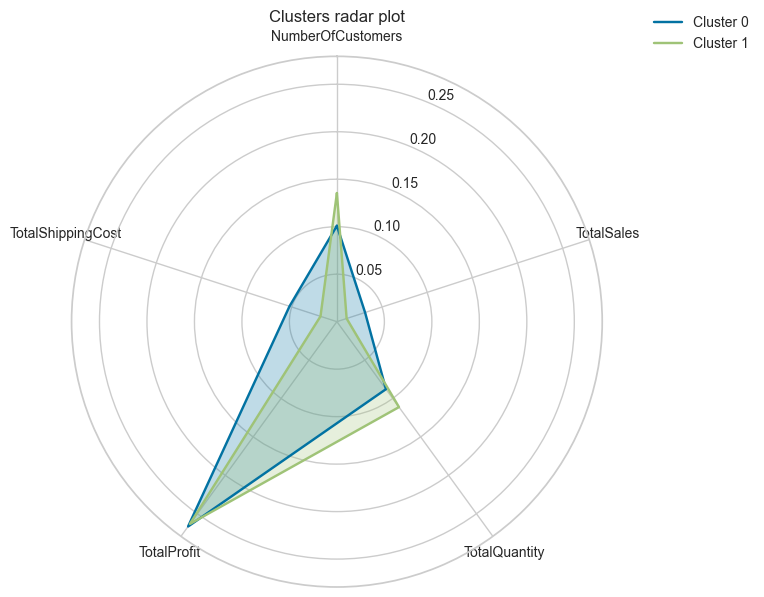

In [12]:
variables = ['NumberOfCustomers', 'TotalSales',
       'TotalQuantity', 'TotalProfit', 'TotalShippingCost']

plot_radar(df_kmeans, variables)

### Histograms

Below, we can see a more detailed distribution of the variables based on the cluster. We can confirm that there is indeed a division by categories and that the rest of the variables are distributed according to the characteristics of each category.

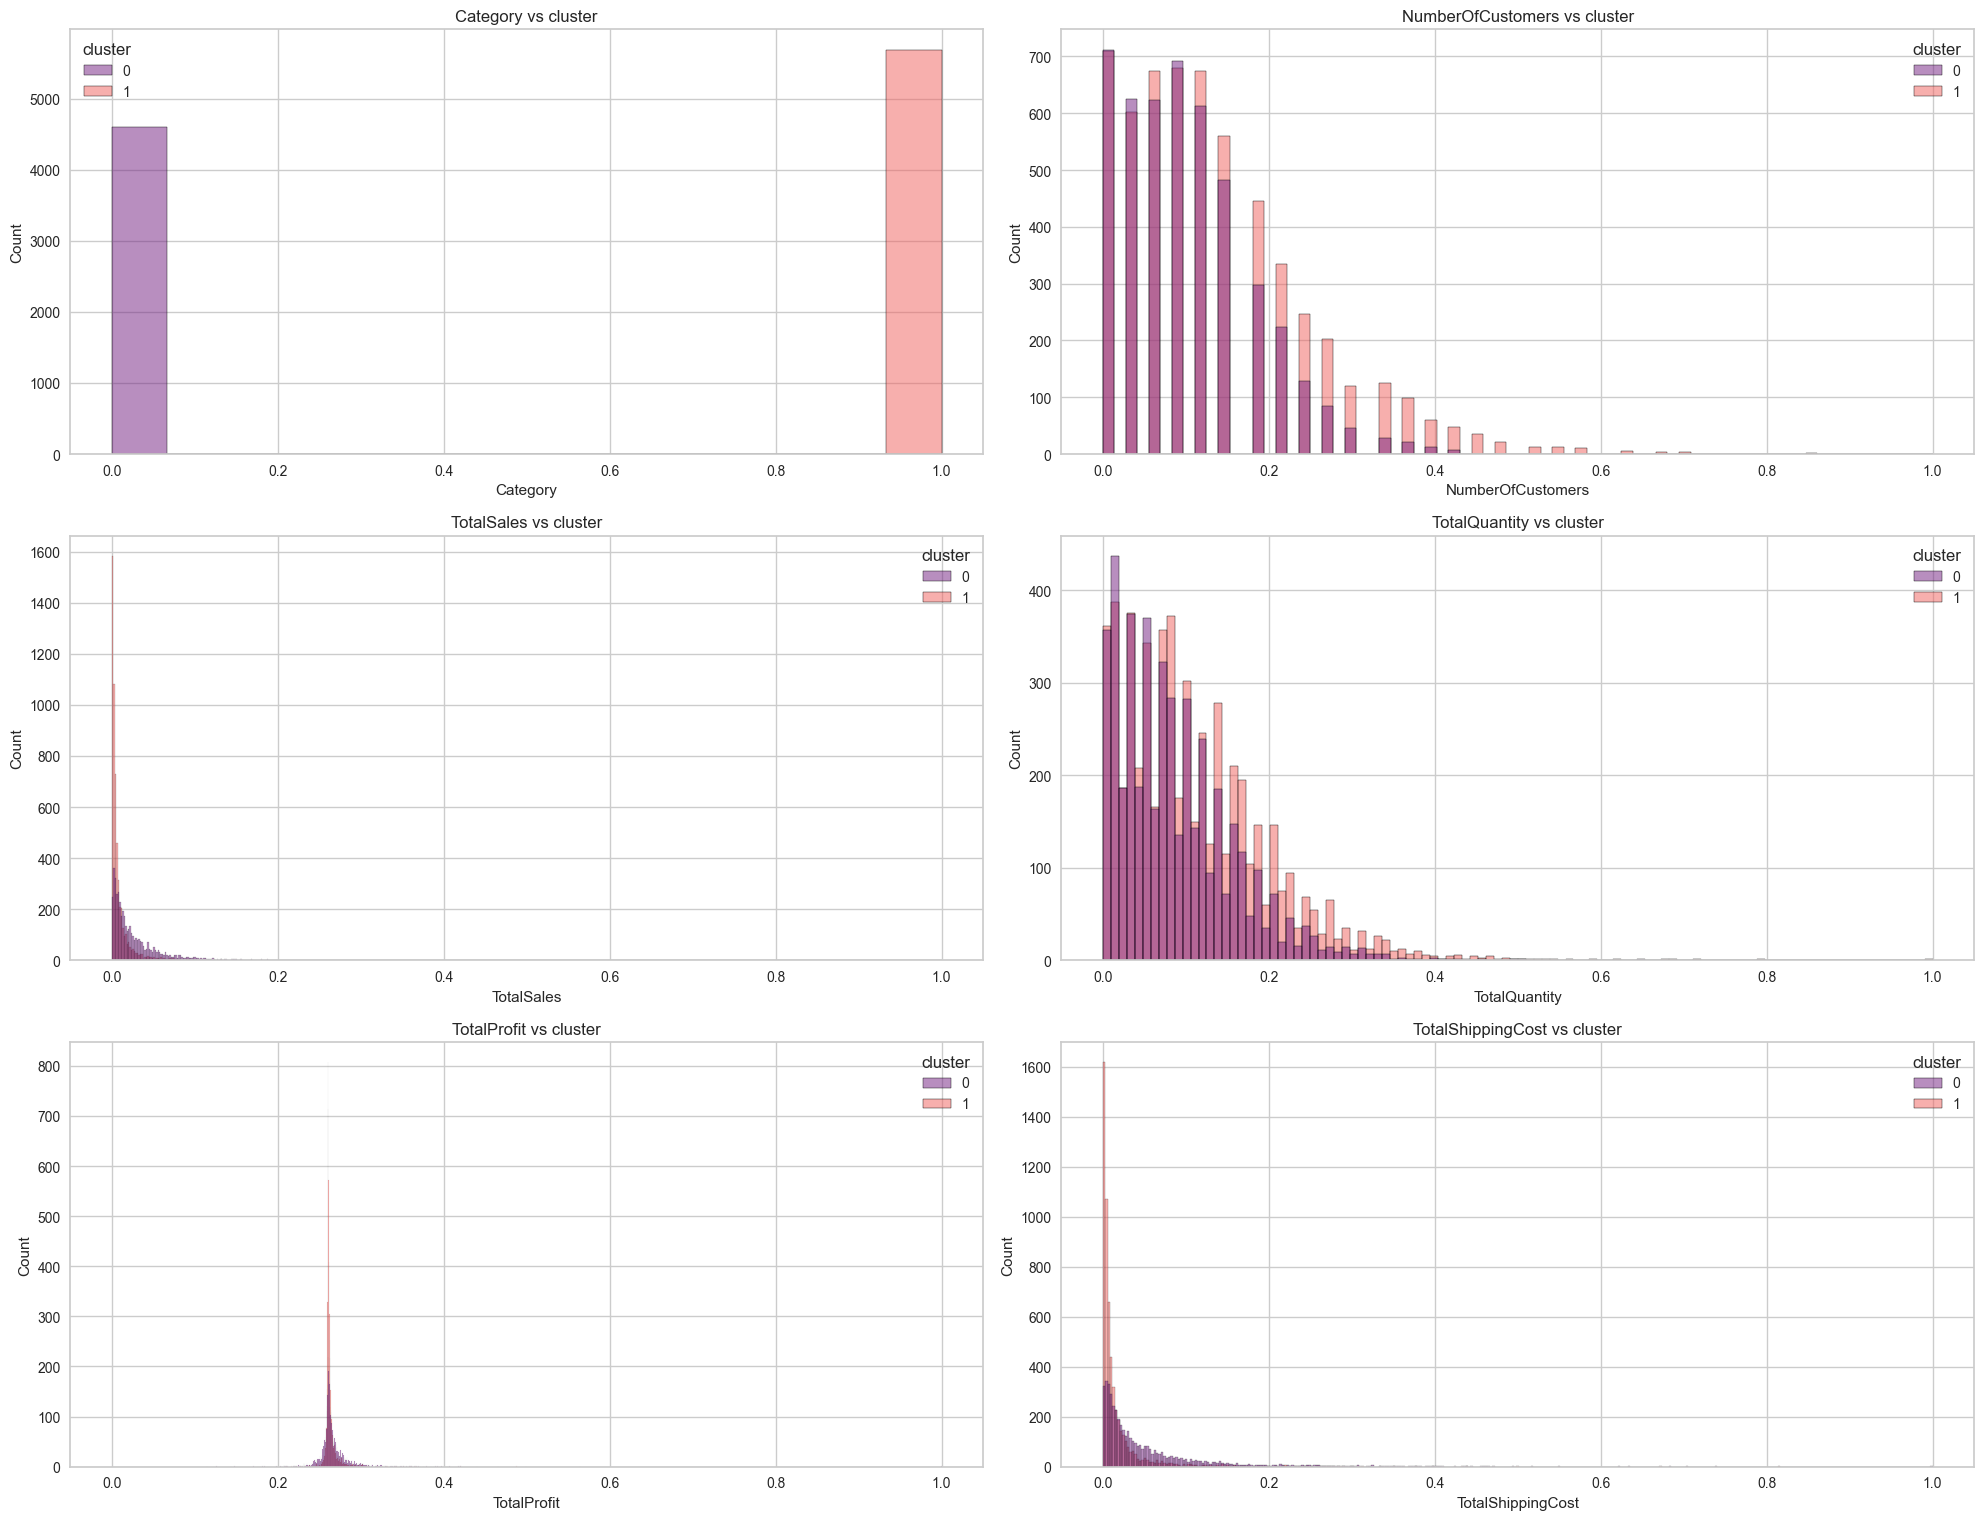

In [13]:
plot_relation_tv(df_kmeans, 'cluster', size=(20, 20), n_cols = 2)

We see once again that the main difference is the categorization. There are also slight differences in the level of sales and shipping costs, even though the profit is identical. This could be a key point for further analysis.

## 4.2 Agglomerative clustering

This time, we will use an agglomerative hierarchical clustering model.  

Let’s start by visualizing the dendrograms associated with each type of linkage we can use.

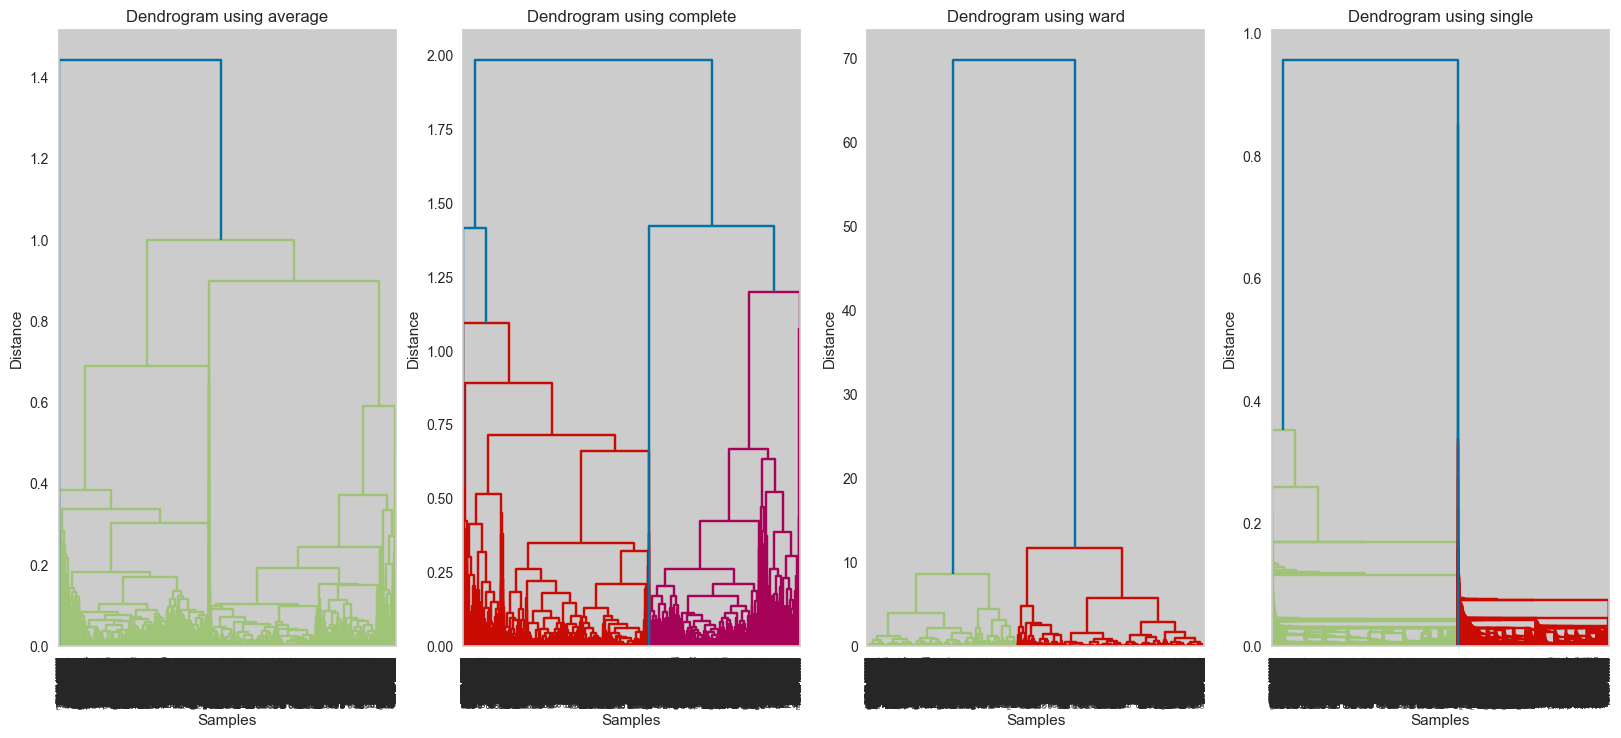

In [14]:
df_copy = df_scaled.copy()

plot_dendrogram(df_copy)

In [15]:
results_df = agglomerative_methods(df_copy)

Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.


In [16]:
best_model = results_df.sort_values(by='ranking_score', ascending=False).iloc[0]

best_model

linkage                           complete
metric                           euclidean
silhouette_score                   0.83521
davies_bouldin_index              0.240917
cluster_cardinality     {0: 4603, 1: 5689}
n_cluster                                2
balance_score                     1.235933
ranking_score                     -0.64164
Name: 0, dtype: object

The best model uses a 'complete' linkage and a Euclidean metric.

In [17]:
model = AgglomerativeClustering(
    linkage=best_model['linkage'],
    metric=best_model['metric'],
    distance_threshold=None,
    n_clusters=best_model['n_cluster']
)

agglo_fit = model.fit(df_scaled)
agglo_labels = agglo_fit.labels_

### 4.2.1 Metrics

In [18]:
clustering_metrics(df_scaled, agglo_labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.83521,0.240917,4603
1,0.83521,0.240917,5689


The metrics and clusters obtained are practically identical to those from K-Means clustering.

### 4.2.2 Cluster exploration

In [19]:
df_agg = df_scaled.copy()
df_agg["cluster"] = agglo_labels

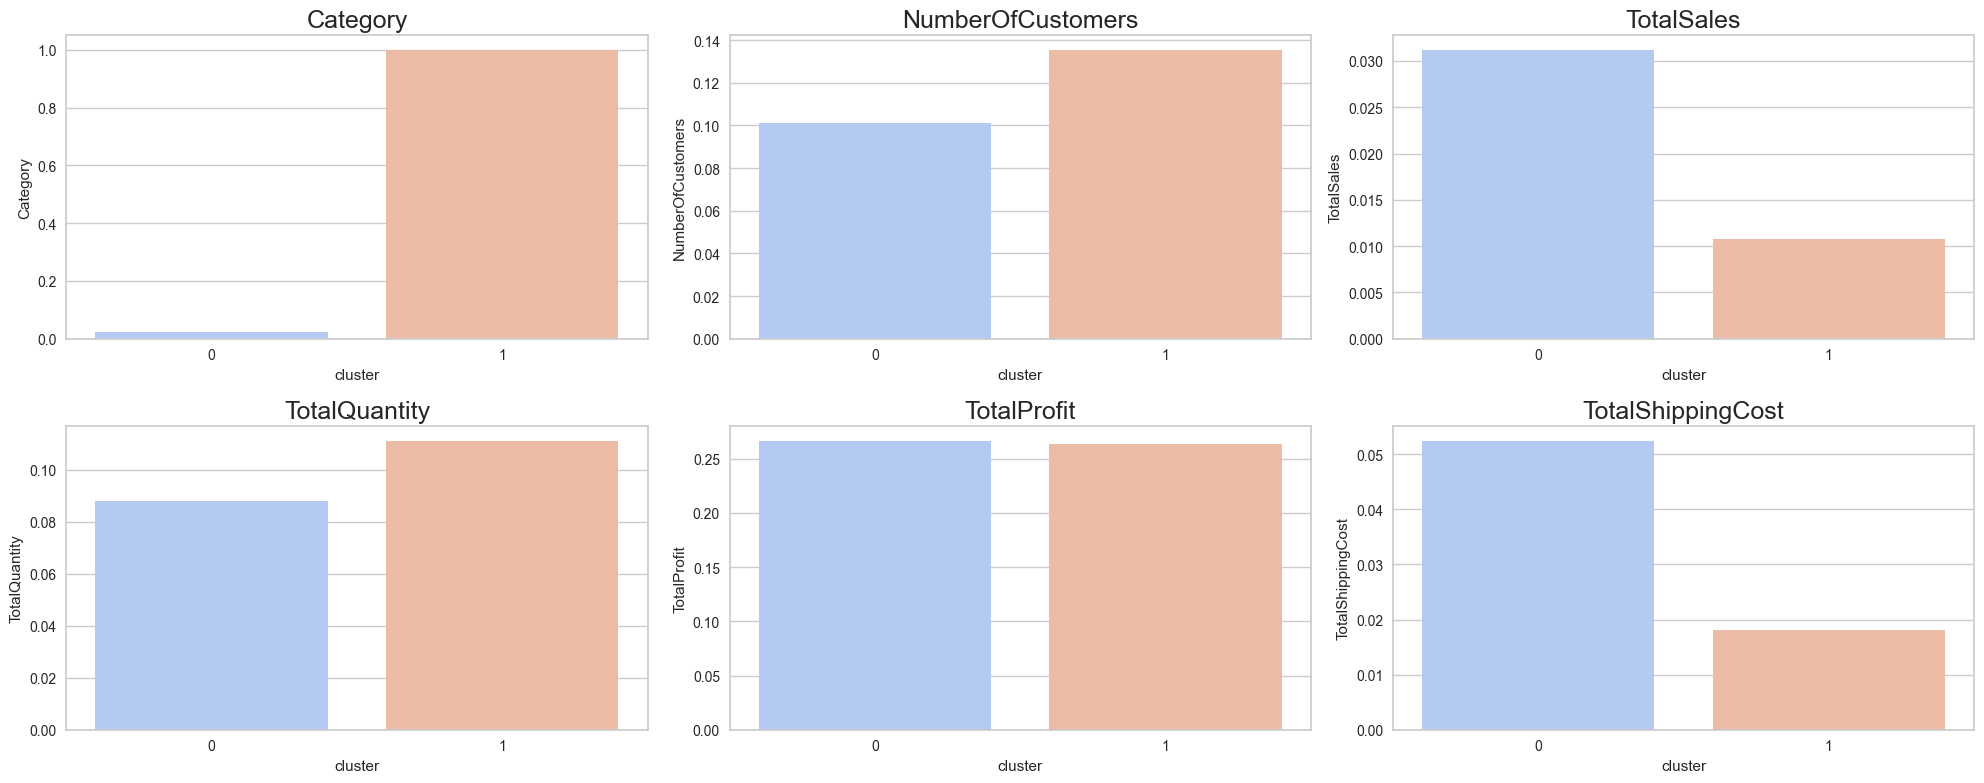

In [20]:
plot_clusters(df_agg)

#### Radar plot

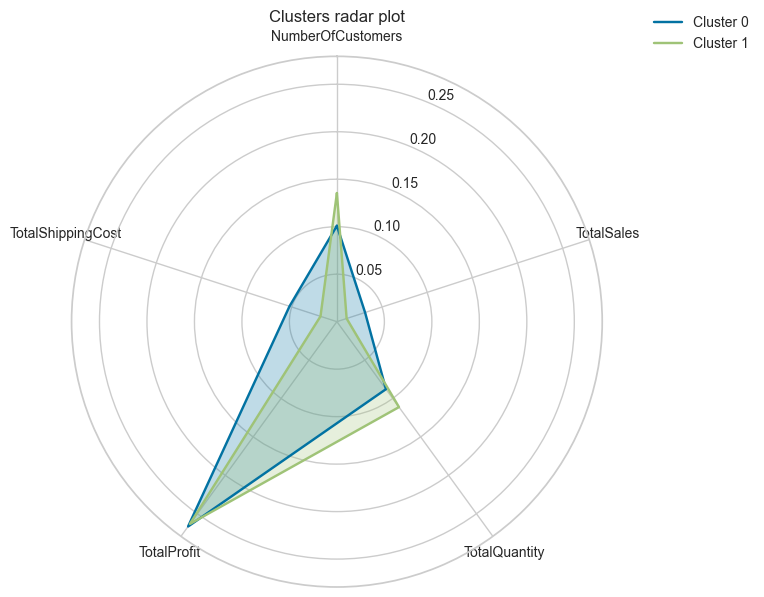

In [21]:
# Select variables to display in radar plot
variables = ['NumberOfCustomers', 'TotalSales',
       'TotalQuantity', 'TotalProfit', 'TotalShippingCost']

plot_radar(df_agg, variables)

#### Histograms

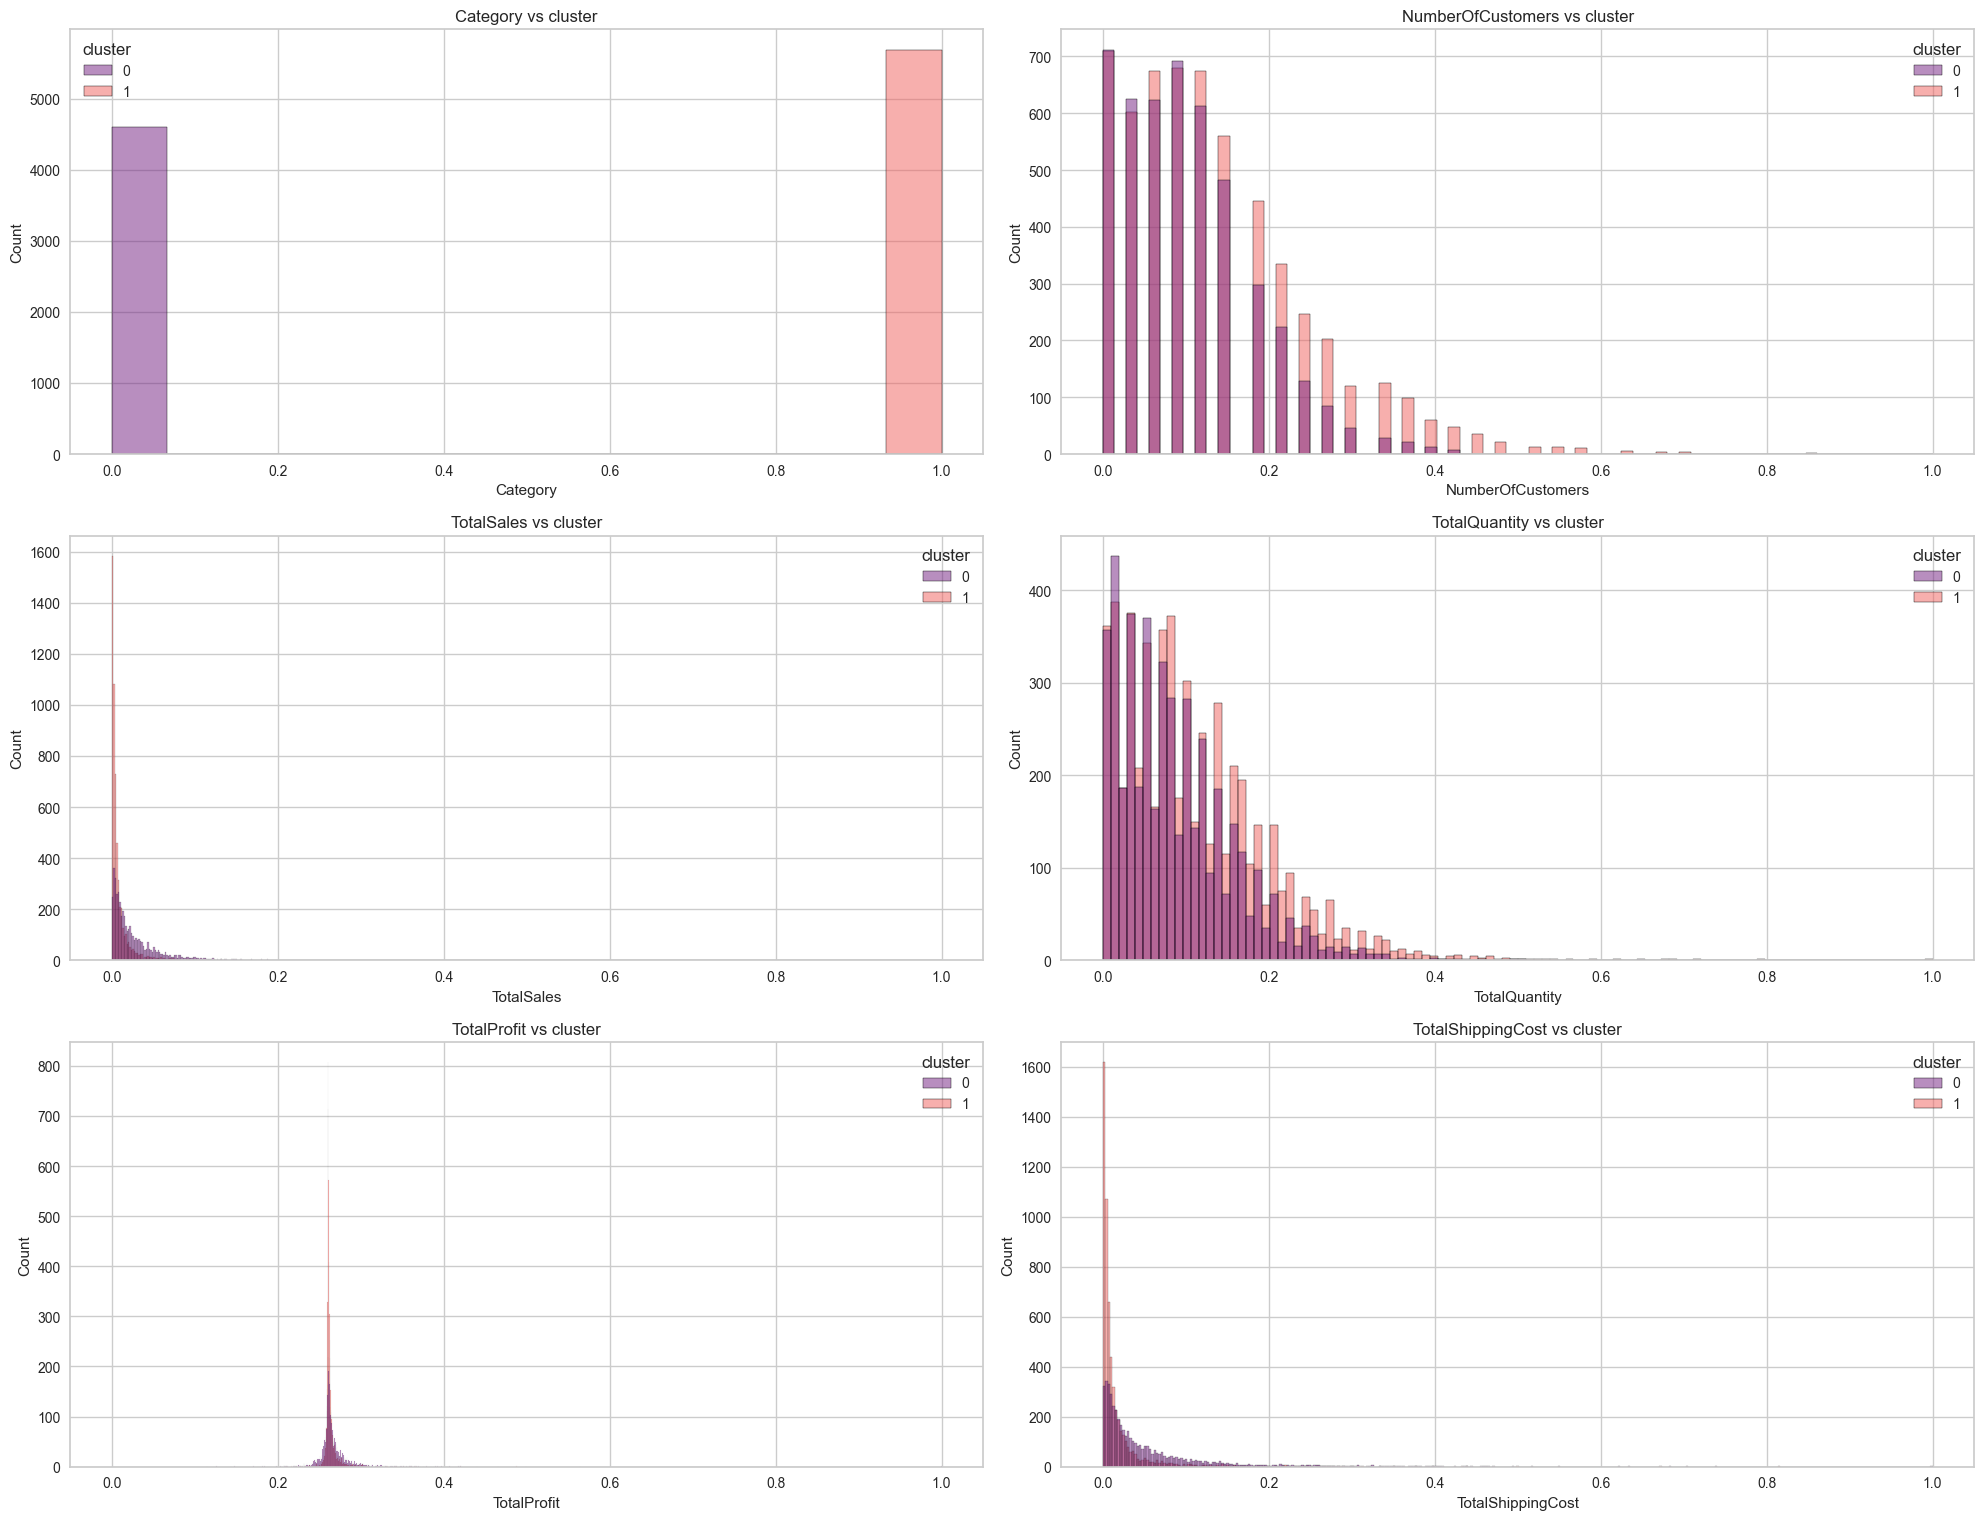

In [22]:
plot_relation_tv(df_agg, 'cluster', size=(20,20), n_cols = 2)

Indeed, we arrive at the same conclusions as before.

## 4.3 Spectral clustering

This method takes a long time to run on this dataset, so we will discard it for now.

## 4.4 DBSCAN Clustering

Next, let’s test the DBSCAN method with different values of epsilon and min_samples.

In [23]:
dbscan_methods(df_scaled, eps_values=[0.1, 0.5, 1], min_samples_values=[3, 5, 10, 15])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
4,0.5,3,0.835081,0.191067,"{-1: 1, 0: 4602, 1: 5689}"
5,0.5,5,0.835081,0.191067,"{-1: 1, 0: 4602, 1: 5689}"
6,0.5,10,0.835081,0.191067,"{-1: 1, 0: 4602, 1: 5689}"
7,0.5,15,0.835081,0.191067,"{-1: 1, 0: 4602, 1: 5689}"
1,0.1,5,0.813099,1.074318,"{-1: 57, 0: 4576, 1: 5659}"
2,0.1,10,0.811265,1.051677,"{-1: 69, 0: 4568, 1: 5655}"
3,0.1,15,0.804207,1.058428,"{-1: 92, 0: 4556, 1: 5644}"
0,0.1,3,0.738094,0.994823,"{-1: 42, 0: 4578, 1: 5660, 2: 4, 3: 8}"
8,1.0,3,-1.000000,NaN,{'Unique cluster': 10292}
9,1.0,5,-1.000000,NaN,{'Unique cluster': 10292}


In this case, different combinations of `epsilon` and `min_samples` lead us to conclude that the only acceptable models are very similar to those obtained with the previous algorithms, with the exception that this time a third cluster is generated containing a single element.  

This element could be sufficiently anomalous to not be captured by either of the other two clusters. This is entirely possible, but we leave its study for future analyses.

For now, we will discard the DBSCAN method for clustering.

# 5. Conclusions

We obtained the same clustering using K-Means and hierarchical clustering (agglomerative clustering), resulting in two clusters with a clear difference in categories, as well as in sales and shipping costs.  

In this case, we used a different preprocessing approach than in the previous Jupyter Notebook, improving the clustering and obtaining clusters that, at first glance, seem to make more sense.  

To proceed with the next step, we will adopt the clustering using K-Means with 2 clusters and the preprocessing from this notebook.

# 6. Data saving

In [28]:
df.head()

,Category,Sub-Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
ProductID,,,,,,,
FUR-ADV-10000002,Furniture,Furnishings,2,159.120,3,60.390,10.14
FUR-ADV-10000108,Furniture,Furnishings,3,350.070,7,3.360,22.90
FUR-ADV-10000183,Furniture,Furnishings,8,974.832,31,-651.738,100.02
FUR-ADV-10000188,Furniture,Furnishings,5,124.950,7,4.200,16.53
FUR-ADV-10000190,Furniture,Furnishings,1,222.360,2,104.460,32.71


In [29]:
df_kmeans.head()

,Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost,cluster
ProductID,,,,,,,
FUR-ADV-10000002,0.0,0.030303,0.002557,0.012346,0.262335,0.002580,0
FUR-ADV-10000108,0.0,0.060606,0.005657,0.037037,0.260662,0.005833,0
FUR-ADV-10000183,0.0,0.212121,0.015799,0.185185,0.241439,0.025492,0
FUR-ADV-10000188,0.0,0.121212,0.002002,0.037037,0.260687,0.004209,0
FUR-ADV-10000190,0.0,0.000000,0.003583,0.006173,0.263628,0.008333,0


In [33]:
df_clusters = pd.concat([df, df_kmeans['cluster']], axis=1)

In [34]:
df_clusters.to_csv('../data/processed/products_clusters.csv')